# What's considered a source in a data pipeline?

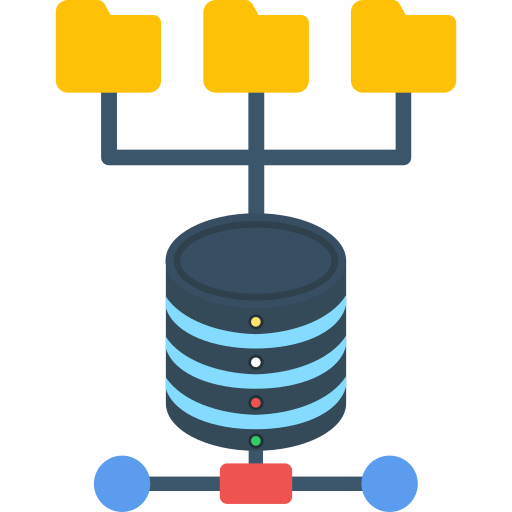

You could have data flowing into your pipeline from a:
- payment service
- or a database
- or notion page/airtable/google sheet
- or a sensor
- or a mobile app
- or even a csv file or pandas dataframe!

Do you have any examples of weird data sources you've worked with? 👀


# Load data from variety of sources

Let's first look at the simplest ways to load data into a database using dlt

In [15]:
%%capture
!pip install dlt[duckdb]

## From dataframe


In [16]:
import dlt
import pandas as pd
import duckdb

sample_df = pd.DataFrame({
    "id": [0,1,2],
    "city": ["Berlin", "Dublin", "Naples"]
})

pipeline = dlt.pipeline(
    pipeline_name='from_dataframe',
    destination='duckdb',
    dataset_name='sample_data',
    dev_mode=True
)

load_info = pipeline.run(sample_df, table_name='cities')
print(load_info)

Pipeline from_dataframe load step completed in 1.64 seconds
1 load package(s) were loaded to destination duckdb and into dataset sample_data_20240902014805
The duckdb destination used duckdb:////content/from_dataframe.duckdb location to store data
Load package 1725241685.9239025 is LOADED and contains no failed jobs


## From database

In [17]:
%%capture
!pip install pymysql

In [18]:
import dlt
from sqlalchemy import create_engine

# Use any SQL database supported by SQLAlchemy, below we use a public
# MySQL instance to get data.
# NOTE: you'll need to install pymysql with `pip install pymysql`
# NOTE: loading data from public mysql instance may take several seconds
engine = create_engine("mysql+pymysql://rfamro@mysql-rfam-public.ebi.ac.uk:4497/Rfam")

with engine.connect() as conn:
    # Select genome table, stream data in batches of 100 elements
    query = "SELECT * FROM genome LIMIT 1000"
    rows = conn.execution_options(yield_per=100).exec_driver_sql(query)

    pipeline = dlt.pipeline(
        pipeline_name="from_database",
        destination="duckdb",
        dataset_name="genome_data",
    )

    # Convert the rows into dictionaries on the fly with a map function
    load_info = pipeline.run(map(lambda row: dict(row._mapping), rows), table_name="genome")

print(load_info)

Pipeline from_database load step completed in 2.20 seconds
1 load package(s) were loaded to destination duckdb and into dataset genome_data
The duckdb destination used duckdb:////content/from_database.duckdb location to store data
Load package 1725241709.273586 is LOADED and contains no failed jobs


## From API
Below we load 100 most recent issues from our own dlt repository into "issues" table.

When creating a schema during normalization, dlt recursively unpacks this nested structure into relational tables, creating and linking children and parent tables.


In [19]:
import dlt
import requests


# url to request dlt-hub/dlt issues
url = "https://api.github.com/repos/dlt-hub/dlt/issues"
# make the request and check if succeeded
response = requests.get(url)
response.raise_for_status()

pipeline = dlt.pipeline(
    pipeline_name='from_api',
    destination='duckdb',
    dataset_name='mydata',
    dev_mode=True
)
load_info = pipeline.run(response.json(), table_name="issues")
print(load_info)

Pipeline from_api load step completed in 1.30 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata_20240902014920
The duckdb destination used duckdb:////content/from_api.duckdb location to store data
Load package 1725241760.9847388 is LOADED and contains no failed jobs


# Resources & Sources

dlt comes up with a way for you to manage the data flowing into your pipeline using [resources](https://dlthub.com/docs/general-usage/resource) and [sources](https://dlthub.com/docs/general-usage/source).

In the context of the dlt library, a `source` is a logical grouping of `resources`, typically representing endpoints of a single AP or tables in database. It is a function decorated with `@dlt.source` that returns one or more resources. Sources are useful for defining schemas with tables, columns, performance hints, and more. They also contain the authentication and pagination code for a particular API, making them essential for data extraction and transformation.

A resource, on the other hand, is a logical grouping of data within a data source, typically holding data of similar structure and origin. For example, if the source is an API, then a resource is an endpoint in that API. Resources are useful as they represent the actual data that is extracted from the source location.


```
                  Source
               /          \
          Resource1  ...  ResourceN

```

# Using a dlt resource

Let's take GitHub API for example and turn it into a dlt resource.

In [20]:
import dlt
import requests


@dlt.resource(table_name='issues')
def github_issues():
    # url to request dlt-hub/dlt issues
    url = "https://api.github.com/repos/dlt-hub/dlt/issues"
    # make the request and check if succeeded
    response = requests.get(url)
    response.raise_for_status()
    yield response.json()


pipeline = dlt.pipeline(
    pipeline_name='resource_data',
    destination='duckdb',
    dataset_name='mydata',
    dev_mode=True
)
load_info = pipeline.run(github_issues())
print(load_info)

Pipeline resource_data load step completed in 1.30 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata_20240902014946
The duckdb destination used duckdb:////content/resource_data.duckdb location to store data
Load package 1725241786.4244027 is LOADED and contains no failed jobs


The `@dlt.resource` decorator takes a bunch of arguments that help you control the schema of your data.

## Let's check out the loaded data

In [21]:
conn = duckdb.connect('resource_data.duckdb')
conn.sql('SHOW ALL TABLES')

┌───────────────┬──────────────────────┬─────────────────────┬──────────────────────┬──────────────────────┬───────────┐
│   database    │        schema        │        name         │     column_names     │     column_types     │ temporary │
│    varchar    │       varchar        │       varchar       │      varchar[]       │      varchar[]       │  boolean  │
├───────────────┼──────────────────────┼─────────────────────┼──────────────────────┼──────────────────────┼───────────┤
│ resource_data │ mydata_20240902014…  │ _dlt_loads          │ [load_id, schema_n…  │ [VARCHAR, VARCHAR,…  │ false     │
│ resource_data │ mydata_20240902014…  │ _dlt_pipeline_state │ [version, engine_v…  │ [BIGINT, BIGINT, V…  │ false     │
│ resource_data │ mydata_20240902014…  │ _dlt_version        │ [version, engine_v…  │ [BIGINT, BIGINT, T…  │ false     │
│ resource_data │ mydata_20240902014…  │ issues              │ [url, repository_u…  │ [VARCHAR, VARCHAR,…  │ false     │
│ resource_data │ mydata_2024090

You can see that dlt unnested the data and created child tables.

Special tables are created to track the pipeline state. These tables are prefixed with `_dlt_`.

Read more about [destination tables](https://dlthub.com/docs/general-usage/destination-tables).

In [26]:
# view the created table from dlt decorator. mydata_20240902014946.issues = schema and table_name. same as below code
conn.sql('SELECT * FROM mydata_20240902014946.issues')

┌──────────────────────┬──────────────────────┬───┬──────────────────────┬────────────────┬──────────────────────┐
│         url          │    repository_url    │ … │ assignee__received…  │ assignee__type │ assignee__site_admin │
│       varchar        │       varchar        │   │       varchar        │    varchar     │       boolean        │
├──────────────────────┼──────────────────────┼───┼──────────────────────┼────────────────┼──────────────────────┤
│ https://api.github…  │ https://api.github…  │ … │ NULL                 │ NULL           │ NULL                 │
│ https://api.github…  │ https://api.github…  │ … │ https://api.github…  │ User           │ false                │
│ https://api.github…  │ https://api.github…  │ … │ https://api.github…  │ User           │ false                │
│ https://api.github…  │ https://api.github…  │ … │ NULL                 │ NULL           │ NULL                 │
│ https://api.github…  │ https://api.github…  │ … │ https://api.github…  │ User 

Let's check out the tables we created

In [25]:
conn.sql(f'select * from {pipeline.dataset_name}.issues')

┌──────────────────────┬──────────────────────┬───┬──────────────────────┬────────────────┬──────────────────────┐
│         url          │    repository_url    │ … │ assignee__received…  │ assignee__type │ assignee__site_admin │
│       varchar        │       varchar        │   │       varchar        │    varchar     │       boolean        │
├──────────────────────┼──────────────────────┼───┼──────────────────────┼────────────────┼──────────────────────┤
│ https://api.github…  │ https://api.github…  │ … │ NULL                 │ NULL           │ NULL                 │
│ https://api.github…  │ https://api.github…  │ … │ https://api.github…  │ User           │ false                │
│ https://api.github…  │ https://api.github…  │ … │ https://api.github…  │ User           │ false                │
│ https://api.github…  │ https://api.github…  │ … │ NULL                 │ NULL           │ NULL                 │
│ https://api.github…  │ https://api.github…  │ … │ https://api.github…  │ User 

Additionally dlt creates special columns.

* The `_dlt_load_id` is a unique identifier for each load package.

* The `_dlt_id` is a unique identifier for each row in all data tables created by dlt.



* Note: The `_dlt_load_id` and `_dlt_id` columns are not added by default when loading Arrow tables or Pandas dataframes directly to maintain the best performance and avoid unnecessary data copying. However, when you use a `@dlt.resource` decorated function, these columns are added by default.


## In our resource, why do we `yield` and not `return`? 🤔



```py
@dlt.resource(table_name='issues')
def github_issues():
    # url to request dlt-hub/dlt issues
    url = "https://api.github.com/repos/dlt-hub/dlt/issues"
    # make the request and check if succeeded
    response = requests.get(url)
    response.raise_for_status()
    yield response.json()
```

Refresher on `yield` and `return`:
- `return` is used to exit a function and send a value back to the caller after computing a result.
- `yield` turns a function into a **generator** which can send a sequence of values back to the caller, one at a time.
  - instead of generating all the values at once and storing them in memory, it generates them one at a time.
  - this leads to efficient memory management.
  - seems like something that has a pretty good use case for streaming data :)


# Transformers

Feed the data of one resource into another. For example, you can use one resource to retrieve a list of repositories, and another that retrieves the issues of those repositories.

- resource 1 -> resource 2

- dlt-hub repos -> repo issues

In [35]:
import dlt
import requests


@dlt.resource(table_name='repos')
def github_repos():
    # url to request dlt-hub/dlt repos
    url = "https://api.github.com/orgs/dlt-hub/repos"
    # make the request and check if succeeded
    response = requests.get(url)
    response.raise_for_status()
    yield response.json() # list of json


@dlt.transformer(data_from=github_repos, table_name="issues")
def github_issues(items):
    for item in items[:1]: # data limit for demo
        # url to request dlt-hub/dlt issues
        url = f"https://api.github.com/repos/dlt-hub/{item['name']}/issues"
        # make the request and check if succeeded
        response = requests.get(url)
        response.raise_for_status()
        yield response.json()


pipeline = dlt.pipeline(
    pipeline_name='transformer_data',
    destination='duckdb',
    dataset_name='mydata',
    dev_mode=True
)

load_info = pipeline.run(github_issues())
print(load_info)

Pipeline transformer_data load step completed in 1.17 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata_20240902025329
The duckdb destination used duckdb:////content/transformer_data.duckdb location to store data
Load package 1725245609.095038 is LOADED and contains no failed jobs


In [36]:
conn = duckdb.connect(f'{pipeline.pipeline_name}.duckdb')
conn.sql('show all tables')

┌──────────────────┬──────────────────────┬─────────────────────┬───┬──────────────────────┬───────────┐
│     database     │        schema        │        name         │ … │     column_types     │ temporary │
│     varchar      │       varchar        │       varchar       │   │      varchar[]       │  boolean  │
├──────────────────┼──────────────────────┼─────────────────────┼───┼──────────────────────┼───────────┤
│ transformer_data │ mydata_20240902024…  │ _dlt_loads          │ … │ [VARCHAR, VARCHAR,…  │ false     │
│ transformer_data │ mydata_20240902024…  │ _dlt_pipeline_state │ … │ [BIGINT, BIGINT, V…  │ false     │
│ transformer_data │ mydata_20240902024…  │ _dlt_version        │ … │ [BIGINT, BIGINT, T…  │ false     │
│ transformer_data │ mydata_20240902024…  │ issues              │ … │ [VARCHAR, VARCHAR,…  │ false     │
│ transformer_data │ mydata_20240902024…  │ issues__assignees   │ … │ [VARCHAR, BIGINT, …  │ false     │
│ transformer_data │ mydata_20240902025…  │ _dlt_loads 

As you can see, only issues were loaded, without repos. Let's figure out why.

In [39]:
# another way to see the data. same as above
conn = duckdb.connect('transformer_data.duckdb')
conn.sql('show all tables')

┌──────────────────┬──────────────────────┬─────────────────────┬───┬──────────────────────┬───────────┐
│     database     │        schema        │        name         │ … │     column_types     │ temporary │
│     varchar      │       varchar        │       varchar       │   │      varchar[]       │  boolean  │
├──────────────────┼──────────────────────┼─────────────────────┼───┼──────────────────────┼───────────┤
│ transformer_data │ mydata_20240902024…  │ _dlt_loads          │ … │ [VARCHAR, VARCHAR,…  │ false     │
│ transformer_data │ mydata_20240902024…  │ _dlt_pipeline_state │ … │ [BIGINT, BIGINT, V…  │ false     │
│ transformer_data │ mydata_20240902024…  │ _dlt_version        │ … │ [BIGINT, BIGINT, T…  │ false     │
│ transformer_data │ mydata_20240902024…  │ issues              │ … │ [VARCHAR, VARCHAR,…  │ false     │
│ transformer_data │ mydata_20240902024…  │ issues__assignees   │ … │ [VARCHAR, BIGINT, …  │ false     │
│ transformer_data │ mydata_20240902025…  │ _dlt_loads 

# Using the GitHub API with dlt sources

**First resource:** dlt-hub repositories.

**Second resource:** issues from the all repos.

We can have many more resources, for example for GitHub pull requests or for reactions.

Now, we could do a `pipeline.run` for each resource. Or, we could group them into a single source, and run the pipeline just once.

# Introducing Sources to group the GitHub Resources

In [40]:
@dlt.source
def github_source():
    return github_repos, github_issues

What did we do there, you ask? We used a dlt source.

### A source is a logical grouping of resources i.e. endpoints of a single API.

Why do this?

- this is more efficient than running your resources separately.
- organizes your schema, as well as your code :)

## Let's run the pipeline with this source:

In [41]:
# new dataset to see the differences

pipeline = dlt.pipeline(
    pipeline_name="dlt_sources",
    destination="duckdb",
    dataset_name="github_data_sources",
    dev_mode=True,
)
load_info = pipeline.run(github_source())

In [42]:
conn.sql('show all tables')     # this is for the above @dlt transformer resource and not the @dlt source

┌──────────────────┬──────────────────────┬─────────────────────┬───┬──────────────────────┬───────────┐
│     database     │        schema        │        name         │ … │     column_types     │ temporary │
│     varchar      │       varchar        │       varchar       │   │      varchar[]       │  boolean  │
├──────────────────┼──────────────────────┼─────────────────────┼───┼──────────────────────┼───────────┤
│ transformer_data │ mydata_20240902024…  │ _dlt_loads          │ … │ [VARCHAR, VARCHAR,…  │ false     │
│ transformer_data │ mydata_20240902024…  │ _dlt_pipeline_state │ … │ [BIGINT, BIGINT, V…  │ false     │
│ transformer_data │ mydata_20240902024…  │ _dlt_version        │ … │ [BIGINT, BIGINT, T…  │ false     │
│ transformer_data │ mydata_20240902024…  │ issues              │ … │ [VARCHAR, VARCHAR,…  │ false     │
│ transformer_data │ mydata_20240902024…  │ issues__assignees   │ … │ [VARCHAR, BIGINT, …  │ false     │
│ transformer_data │ mydata_20240902025…  │ _dlt_loads 

In [43]:
# correct code to show the data for @dlt.source
# conn = duckdb.connect('dlt_sources.duckdb'). same as the below line of code
conn = duckdb.connect(f'{pipeline.pipeline_name}.duckdb')
conn.sql('SHOW ALL TABLES')

┌─────────────┬──────────────────────┬─────────────────────┬──────────────────────┬────────────────────────┬───────────┐
│  database   │        schema        │        name         │     column_names     │      column_types      │ temporary │
│   varchar   │       varchar        │       varchar       │      varchar[]       │       varchar[]        │  boolean  │
├─────────────┼──────────────────────┼─────────────────────┼──────────────────────┼────────────────────────┼───────────┤
│ dlt_sources │ github_data_source…  │ _dlt_loads          │ [load_id, schema_n…  │ [VARCHAR, VARCHAR, B…  │ false     │
│ dlt_sources │ github_data_source…  │ _dlt_pipeline_state │ [version, engine_v…  │ [BIGINT, BIGINT, VAR…  │ false     │
│ dlt_sources │ github_data_source…  │ _dlt_version        │ [version, engine_v…  │ [BIGINT, BIGINT, TIM…  │ false     │
│ dlt_sources │ github_data_source…  │ issues              │ [url, repository_u…  │ [VARCHAR, VARCHAR, V…  │ false     │
│ dlt_sources │ github_data_sour

# Control your sources and resources






## Source arguments

**name** - A name of the source which is also the name of the associated schema. If not present, the function name will be used.

**max_table_nesting** - A schema hint that sets the maximum depth of nested table above which the remaining nodes are loaded as structs or JSON.

**root_key** - Enables merging on all resources by propagating root foreign key to child tables. This option is most useful if you plan to change write disposition of a resource to disable/enable merge. Defaults to False.

**schema** - An explicit Schema instance to be associated with the source. If not present, dlt creates a new Schema object with provided name. If such Schema already exists in the same folder as the module containing the decorated function, such schema will be loaded from file.

and others.

Read more about [source arguments.](https://dlthub.com/docs/api_reference/extract/decorators#source)


## Resource arguments

```py
@dlt.resource(table_name='repos')
def github_repos():
    ...
```

**name** - A name of the resource that by default also becomes the name of the table to which the data is loaded. If not present, the name of the decorated function will be used.

**table_name** - An table name, if different from name. This argument also accepts a callable that is used to dynamically create tables for stream-like resources yielding many datatypes.

**max_table_nesting** - A schema hint that sets the maximum depth of nested table above which the remaining nodes are loaded as structs or JSON.

**write_disposition** - Controls how to write data to a table: append, replace, merge.

**columns** - A list, dict or pydantic model of column schemas. Typed dictionary describing column names, data types, write disposition and performance hints that gives you full control over the created table schema.
Example: `columns={"<column_name>": {"data_type": "complex"}}`.

and others.

Read more about [resource arguments](https://dlthub.com/docs/api_reference/extract/decorators#resource).

## Use hints

`apply_hints()` - Creates or modifies existing table schema by setting provided hints.



In [44]:
@dlt.resource(table_name='repos')
def github_repos():
    # url to request dlt-hub/dlt repos
    url = "https://api.github.com/orgs/dlt-hub/repos"
    # make the request and check if succeeded
    response = requests.get(url)
    response.raise_for_status()
    yield response.json() # list of json


data = github_repos()
data.apply_hints(table_name="new_name_repos")

load_info = pipeline.run(data)
conn = duckdb.connect(f'{pipeline.pipeline_name}.duckdb')
conn.sql('show all tables')

┌─────────────┬──────────────────────┬──────────────────────┬──────────────────────┬───────────────────────┬───────────┐
│  database   │        schema        │         name         │     column_names     │     column_types      │ temporary │
│   varchar   │       varchar        │       varchar        │      varchar[]       │       varchar[]       │  boolean  │
├─────────────┼──────────────────────┼──────────────────────┼──────────────────────┼───────────────────────┼───────────┤
│ dlt_sources │ github_data_source…  │ _dlt_loads           │ [load_id, schema_n…  │ [VARCHAR, VARCHAR, …  │ false     │
│ dlt_sources │ github_data_source…  │ _dlt_pipeline_state  │ [version, engine_v…  │ [BIGINT, BIGINT, VA…  │ false     │
│ dlt_sources │ github_data_source…  │ _dlt_version         │ [version, engine_v…  │ [BIGINT, BIGINT, TI…  │ false     │
│ dlt_sources │ github_data_source…  │ issues               │ [url, repository_u…  │ [VARCHAR, VARCHAR, …  │ false     │
│ dlt_sources │ github_data_sour

In [45]:
data = github_source()
data.github_repos.apply_hints(table_name="another_new_name_repos")

load_info = pipeline.run(data)
conn = duckdb.connect(f'{pipeline.pipeline_name}.duckdb')
conn.sql('show all tables')

┌─────────────┬──────────────────────┬──────────────────────┬──────────────────────┬───────────────────────┬───────────┐
│  database   │        schema        │         name         │     column_names     │     column_types      │ temporary │
│   varchar   │       varchar        │       varchar        │      varchar[]       │       varchar[]       │  boolean  │
├─────────────┼──────────────────────┼──────────────────────┼──────────────────────┼───────────────────────┼───────────┤
│ dlt_sources │ github_data_source…  │ _dlt_loads           │ [load_id, schema_n…  │ [VARCHAR, VARCHAR, …  │ false     │
│ dlt_sources │ github_data_source…  │ _dlt_pipeline_state  │ [version, engine_v…  │ [BIGINT, BIGINT, VA…  │ false     │
│ dlt_sources │ github_data_source…  │ _dlt_version         │ [version, engine_v…  │ [BIGINT, BIGINT, TI…  │ false     │
│ dlt_sources │ github_data_source…  │ another_new_name_r…  │ [id, node_id, name…  │ [BIGINT, VARCHAR, V…  │ false     │
│ dlt_sources │ github_data_sour

# That's it for sources and resources, and how you can declare them in dlt 🥳

You can find out what else you can do with them in our [docs](https://dlthub.com/docs/general-usage). If you have more questions or conversations to start about these topics, come join us in our [slack](https://dlthub.com/community).